## 1. Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.

In [ ]:
import pickle
import cv2
import glob
import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from moviepy.editor import VideoFileClip
from IPython.display import HTML
%matplotlib inline

In [2]:
# Define a function to generate mtx and dist
def cal_undist_params(read_path='camera_cal', out_path='output_images'):
    objpoints = [] # 3D points in real world space
    imgpoints = [] # 2D points in image plane

    # prepare object points, eg: (0,0,0,), (1,0,0), (2,0,0)
    objp = np.zeros((6*9,3), np.float32)
    objp [:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2) #x, y coordinates

    for file_name in os.listdir(read_path):
        # Read in each image in camera_cal folder
        image = mpimg.imread(os.path.join(read_path , file_name))
#         image = cv2.imread(read_path + '/' + file_name)
#         image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        
        # Convert to grayscale
        gray = cv2.cvtColor(image,cv2.COLOR_BGR2GRAY)
        # Find corners
        ret, corners = cv2.findChessboardCorners(gray, (9,6), None)

        if ret == True:
            imgpoints.append(corners)
            objpoints.append(objp)

    # Calibrate each image
    for file_name in os.listdir(read_path):
        # Read in each image in camera_cal folder
        image = mpimg.imread(os.path.join(read_path , file_name))
#         image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        out_image = np.copy(image)
        gray_out_image = cv2.cvtColor(out_image,cv2.COLOR_BGR2GRAY)
        # Perform the camera calibration
        ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray_out_image.shape[::-1], None, None)
        # Undistort image
        undist_img = cv2.undistort(gray_out_image, mtx, dist, None, mtx)
        # Write to output folder
        cv2.imwrite(os.path.join(out_path , file_name), undist_img)
        
        
    return mtx, dist



## 2. Apply a distortion correction to raw images.

In [3]:
mtx, dist = cal_undist_params('camera_cal', 'output_images')

def undist_img_in_folder(mtx, dist, read_path='test_images', out_path='output_images'):
    for file_name in os.listdir(read_path):
        image = mpimg.imread(file_name)
        undist = undist_single_img(mtx, dist, image, out_path)
    return 
     
def undist_single_img(mtx, dist, image, out_path='output_images'):
    
    # Undistort image
    undist = cv2.undistort(image, mtx, dist, None, mtx)
    # Write to output folder
    cv2.imwrite(os.path.join(out_path , file_name), undist)
    
    return undist
       
file_name = 'test_images/test2.jpg'
# Undistort raw images

# Read in each image in camera_cal folder
#     image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
# image = mpimg.imread(file_name)+
# undist = undist_single_img(mtx, dist, image, 'output_images')

# plt.imshow(undist)
# undist = cv2.cvtColor(undist, cv2.COLOR_BGR2RGB)
# cv2.imwrite(os.path.join('output_images' , 'undist_image.jpg'), undist)


## 3. Use color transforms, gradients, etc., to create a thresholded binary image.

In [16]:
# Calculate directional gradient and apply threshold
def abs_sobel_thresh(image, orient='x', sobel_kernel=3, threshold=(20, 100)):
    thresh_min = threshold[0]
    thresh_max = threshold[1]
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    
    # Take the derivative in x or y given orient = 'x' or 'y'
    if orient == 'x':
        sobel = cv2.Sobel(gray, cv2.CV_64F, 1, 0)
    if orient == 'y':
        sobel = cv2.Sobel(gray, cv2.CV_64F, 0, 1)
            
    # Take the absolute value of the derivative or gradient
    abs_sobel = np.absolute(sobel)
    # Scale to 8-bit (0 - 255) and convert to type = np.uint8
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))

    grad_binary = np.zeros_like(scaled_sobel)
    grad_binary[(scaled_sobel >= thresh_min) & (scaled_sobel <= thresh_max)] = 1
    
    return grad_binary

# Calculate gradient magnitude and apply threshold
def mag_thresh(image, sobel_kernel=9, mag_threshold=(30, 100)):
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    
    # Take the gradient in x and y separately
    abs_sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    abs_sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    
    # Calculate the magnitude 
    gradmag = np.sqrt(abs_sobelx**2 + abs_sobely**2)
    
    # Scale to 8-bit (0 - 255) and convert to type = np.uint8
    scaled_sobel = (255*gradmag/np.max(gradmag)).astype(np.uint8) 

    mag_binary = np.zeros_like(scaled_sobel)
    mag_binary[(scaled_sobel >= mag_threshold[0]) & (scaled_sobel <= mag_threshold[1])] = 1
    
    return mag_binary

# Calculate gradient direction and apply threshold
def dir_threshold(image, sobel_kernel=3, threshold=(0.7, 1.3)):
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    # Take the gradient in x and y separately and take the absolute value of them
    sobelx = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel))
    sobely = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel))
    
    # Calculate the direction of the gradient 
    absgraddir = np.arctan2(sobely, sobelx)

    #Create a binary mask where direction thresholds are met
    dir_binary = np.zeros_like(absgraddir)
    dir_binary[(absgraddir >= threshold[0]) & (absgraddir <= threshold[1])] = 1
    
    return dir_binary

# Define a function that thresholds the S-channel of HLS
def hls_select(image, threshold=(170, 255)):
    # Convert to HLS color space
    hls = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
    H = hls[:,:,0]
    L = hls[:,:,1]
    S = hls[:,:,2]
    
    # Apply a threshold to the S channel
    color_binary = np.zeros_like(S)
    color_binary[(S > threshold[0]) & (S <= threshold[1])] = 1
    
    return color_binary

## 4. Apply a perspective transform to rectify binary image ("birds-eye view").

In [17]:
def warp(image):
    image_size = (image.shape[1], image.shape[0])
    imshape = image.shape

    src = np.float32([[1280,720],[720, 450], [560, 450], [0,720]])
    dst = np.float32([[1280,720],[1280,0],[0,0],[0,720]])
    
    M = cv2.getPerspectiveTransform(src, dst)
    Minv = cv2.getPerspectiveTransform(dst, src)
    warped = cv2.warpPerspective(image, M, image_size, flags=cv2.INTER_LINEAR)

    return warped, M, Minv

In [18]:
def pipeline(image):
    # Undistort raw images
    undist = undist_single_img(mtx, dist, image, 'output_images')
        
    img = np.copy(undist)
    # Convert to HLS color space and separate the V channel
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    l_channel = hls[:,:,1]
    s_channel = hls[:,:,2]
    
    # Choose a Sobel kernel size
    ksize = 9

    # Apply each of the thresholding functions
    gradx = abs_sobel_thresh(undist, orient='x', sobel_kernel=ksize, threshold=(20, 100))
    grady = abs_sobel_thresh(undist, orient='y', sobel_kernel=ksize, threshold=(20, 100))
    mag_binary = mag_thresh(undist, sobel_kernel=ksize, mag_threshold=(30, 100))
    dir_binary = dir_threshold(undist, sobel_kernel=ksize, threshold=(0.7, 1.3))
    color_binary = hls_select(undist, threshold=(170, 255))

    combined_binary = np.zeros_like(dir_binary)
    combined_binary[((gradx == 1) & (grady == 1)) | ((mag_binary == 1) & (dir_binary == 1)) | color_binary == 1 ] = 1

    return combined_binary, undist

# file_name = 'test_images/test2.jpg'
# image = mpimg.imread(file_name)
# combined_binary, undist = pipeline(image)

# binary_warped, M, Minv = warp(combined_binary)

# plt.imshow(binary_warped, cmap='gray')
# cv2.imwrite(os.path.join('output_images' , 'binary_warped.jpg'), binary_warped)

## 5. Detect lane pixels and fit to find the lane boundary.

In [19]:
def find_lane_pixels(binary_warped):
    # Take a histogram of the bottom half of the image
    histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)
    # Create an output image to draw on and visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]//2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # HYPERPARAMETERS
    # Choose the number of sliding windows
    nwindows = 9
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 50

    # Set height of windows - based on nwindows above and image shape
    window_height = np.int(binary_warped.shape[0]//nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated later for each window in nwindows
    leftx_current = leftx_base
    rightx_current = rightx_base

    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),
        (win_xleft_high,win_y_high),(0,255,0), 2) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),
        (win_xright_high,win_y_high),(0,255,0), 2) 
        
        # Identify the nonzero pixels in x and y within the window #
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
        
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices (previously was a list of lists of pixels)
    try:
        left_lane_inds = np.concatenate(left_lane_inds)
        right_lane_inds = np.concatenate(right_lane_inds)
    except ValueError:
        # Avoids an error if the above is not implemented fully
        pass

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]

    return leftx, lefty, rightx, righty, out_img

def fit_polynomial(binary_warped):
    # Find our lane pixels first
    leftx, lefty, rightx, righty, out_img = find_lane_pixels(binary_warped)

    # Fit a second order polynomial to each using `np.polyfit` 
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)

    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    
    try:
        left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
        right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    except TypeError:
        # Avoids an error if `left` and `right_fit` are still none or incorrect
        print('The function failed to fit a line!')
        left_fitx = 1*ploty**2 + 1*ploty
        right_fitx = 1*ploty**2 + 1*ploty

    ## Visualization ##
    # Colors in the left and right lane regions
    out_img[lefty, leftx] = [255, 0, 0]
    out_img[righty, rightx] = [0, 0, 255]

    # Plots the left and right polynomials on the lane lines
    plt.plot(left_fitx, ploty, color='yellow')
    plt.plot(right_fitx, ploty, color='yellow')

    return out_img, ploty, left_fit, right_fit

# fit_poly_img, ploty, left_fit, right_fit = fit_polynomial(binary_warped)
# plt.imshow(fit_poly_img)
# cv2.imwrite(os.path.join('output_images' , 'fit_poly_img.jpg'), fit_poly_img)

## 6. Determine the curvature of the lane and vehicle position with respect to center.

In [20]:
def measure_curvature_real(binary_warped):
    # Define conversions in x and y from pixels space to meters
    ym_per_pix = 3.048/100 # meters per pixel in y dimension
    xm_per_pix = 3.7/900 # meters per pixel in x dimension
    
    fit_poly_img, ploty, left_fit_cr, right_fit_cr = fit_polynomial(binary_warped)

    # Define y-value where we want radius of curvature
    # We'll choose the maximum y-value, corresponding to the bottom of the image
    y_eval = np.max(ploty)
    
    #Implement the calculation of R_curve (radius of curvature)
    left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
    right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
     
    l_fit_x_int = left_fit_cr[0]*fit_poly_img.shape[0]**2 + left_fit_cr[1]*fit_poly_img.shape[0] + left_fit_cr[2]
    r_fit_x_int = right_fit_cr[0]*fit_poly_img.shape[0]**2 + right_fit_cr[1]*fit_poly_img.shape[0] + right_fit_cr[2]
    lane_center_position = (r_fit_x_int + l_fit_x_int) /2
    car_center = fit_poly_img.shape[1]/2
    center_dist = (car_center - lane_center_position) * xm_per_pix
    
    return left_curverad, right_curverad, center_dist


# Calculate the radius of curvature in meters for both lane lines
# left_curverad, right_curverad, center_dist = measure_curvature_real(binary_warped)

# print(left_curverad, 'm', right_curverad, 'm', center_dist, 'm')



## 7. Warp the detected lane boundaries back onto the original image.

In [28]:
def draw_lane(original_img, binary_img, l_fit, r_fit, Minv):
    new_img = np.copy(original_img)
    if l_fit is None or r_fit is None:
        return original_img
    # Create an image to draw the lines on
    warp_zero = np.zeros_like(binary_img).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))
    
    h,w = binary_img.shape
    ploty = np.linspace(0, h-1, num=h)# to cover same y-range as image
    left_fitx = l_fit[0]*ploty**2 + l_fit[1]*ploty + l_fit[2]
    right_fitx = r_fit[0]*ploty**2 + r_fit[1]*ploty + r_fit[2]

    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))
    cv2.polylines(color_warp, np.int32([pts_left]), isClosed=False, color=(255,0,255), thickness=15)
    cv2.polylines(color_warp, np.int32([pts_right]), isClosed=False, color=(0,255,255), thickness=15)

    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, Minv, (w, h)) 
    # Combine the result with the original image
    result = cv2.addWeighted(new_img, 1, newwarp, 0.5, 0)
    return result

# line_on_image = draw_lane(undist, combined_binary, left_fit, right_fit, Minv)

# # line_on_image = cv2.cvtColor(line_on_image, cv2.COLOR_BGR2RGB)
# cv2.imwrite(os.path.join('output_images' , 'line_on_image.jpg'), line_on_image)

# plt.close('all')
# plt.imshow(line_on_image)



## 8. Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

In [29]:
def draw_data(original_img, left_curverad,  right_curverad, center_dist):
    new_img = np.copy(original_img)
    h = new_img.shape[0]
    font = cv2.FONT_HERSHEY_DUPLEX
    text = 'Left radius: ' + '{:04.2f}'.format(left_curverad) + 'm; Right radius:'+ '{:04.2f}'.format(right_curverad) + 'm'
    cv2.putText(new_img, text, (40,70), font, 1.5, (200,255,155), 2, cv2.LINE_AA)
    direction = ''
    if center_dist > 0:
        direction = 'right'
    elif center_dist < 0:
        direction = 'left'
    abs_center_dist = abs(center_dist)
    text = 'Car is ''{:04.3f}'.format(abs_center_dist) + 'm from lane center' +' on the ' + direction
    cv2.putText(new_img, text, (40,120), font, 1.5, (200,255,155), 2, cv2.LINE_AA)
    return new_img

# data_on_image = draw_data(line_on_image, left_curverad,  right_curverad, center_dist)
# plt.close('all')
# plt.imshow(data_on_image)


## 9. Define function to use previous fit for lines

In [30]:
def polyfit_using_prev_fit(binary_warped, left_fit_prev, right_fit_prev):
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    margin = 80
    left_lane_inds = ((nonzerox > (left_fit_prev[0]*(nonzeroy**2) + left_fit_prev[1]*nonzeroy + left_fit_prev[2] - margin)) & 
                      (nonzerox < (left_fit_prev[0]*(nonzeroy**2) + left_fit_prev[1]*nonzeroy + left_fit_prev[2] + margin))) 
    right_lane_inds = ((nonzerox > (right_fit_prev[0]*(nonzeroy**2) + right_fit_prev[1]*nonzeroy + right_fit_prev[2] - margin)) & 
                       (nonzerox < (right_fit_prev[0]*(nonzeroy**2) + right_fit_prev[1]*nonzeroy + right_fit_prev[2] + margin)))  

    # Again, extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]
    
    left_fit_new, right_fit_new = (None, None)
    if len(leftx) != 0:
        # Fit a second order polynomial to each
        left_fit_new = np.polyfit(lefty, leftx, 2)
    if len(rightx) != 0:
        right_fit_new = np.polyfit(righty, rightx, 2)
    return left_fit_new, right_fit_new, left_lane_inds, right_lane_inds

## 10. Define Line class

In [31]:
class Lane():
    def __init__(self):
        self.left_fit = None
        self.right_fit = None
        self.left_fit_m = None
        self.right_fit_m = None
        self.leftCurvature = None
        self.rightCurvature = None

## 11. Final Pipeline of Processing image

In [32]:
def process_image(img):
    image = np.copy(img)
    # Undist image, trasform to binary image combined with s-channel and sobel
    combined_binary, undist = pipeline(image)
    # Warp image
    binary_warped, M, Minv = warp(combined_binary)

    # Find fit for left lane and right lane
    fit_poly_img, ploty, left_fit, right_fit = fit_polynomial(binary_warped)
    # Caculate left and right curve, find distance to center
    left_curverad, right_curverad, center_dist = measure_curvature_real(binary_warped)

    # Draw line and data back on image
    line_on_image = draw_lane(undist, combined_binary, left_fit, right_fit, Minv)
    data_on_image = draw_data(line_on_image, left_curverad, right_curverad, center_dist)
    
    return data_on_image
         
# input_file = 'test_images/test2.jpg'
# raw_image = mpimg.imread(input_file)

# process_image_result = process_image(raw_image)
# plt.close('all')
# plt.imshow(process_image_result)
# process_image_result = cv2.cvtColor(process_image_result, cv2.COLOR_BGR2RGB)
# cv2.imwrite(os.path.join('output_images' , 'process_image_result.jpg'), process_image_result)

## 12. Process Video

[MoviePy] >>>> Building video output_project_video.mp4
[MoviePy] Writing video output_project_video.mp4



 98%|█████████▊| 50/51 [00:21<00:00,  1.93it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: output_project_video.mp4 

CPU times: user 18.6 s, sys: 1.26 s, total: 19.9 s
Wall time: 24.9 s


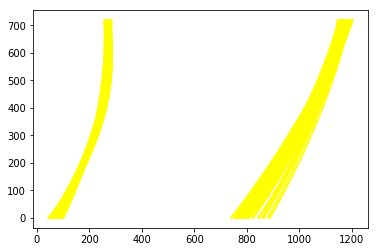

In [33]:
def video_pinpline(input_video, output_video):

    clip = VideoFileClip(input_video).subclip(1, 3)

    leftLane = Lane()
    rightLane = Lane()
    
    
    output_clip = clip.fl_image(process_image)
    %time output_clip.write_videofile(output_video, audio=False)

    
video_pinpline("project_video.mp4", 'output_project_video.mp4')